In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import seaborn as sns

nltk.download("stopwords")
sw_nltk = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\parzy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from datasets import load_dataset, Dataset

label2id = {"sadness": 0, "joy": 1, "love": 2,
            "anger": 3, "fear": 4, "surprise": 5}
id2label = {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise",
}
emotion_list = list(label2id.keys())

dataset_name = "AdamCodd/emotion-balanced"
raw_dataset = load_dataset(dataset_name)

In [10]:
def plot_histogram(df, name=None):
    df = df.copy()
    labels = list(df["label"].unique())
    try:
        for idx, i in enumerate(labels):
            df[i] = df["label"].apply(lambda x: 1 if i in x else 0)
        df.drop(
            [
                "label",
            ],
            axis=1,
            inplace=True,
        )
    except:
        pass
    temp_list = df.drop(["text"], axis=1).sum(axis=0).sort_values()
    print(temp_list)
    plt.bar(temp_list.index, temp_list)
    if name == None:
        plt.title("Rozkład klas")
    else:
        plt.title(name)
    plt.xlabel("Klasa")
    plt.ylabel("Liczba wystąpień")
    plt.xticks(rotation=60, ha="right")
    plt.show()

In [11]:
def hot_encode(df: pd.DataFrame):
    df["label"] = df["label"].map(lambda x: id2label[str(x)])
    one_hot_encoded = pd.get_dummies(df["label"])
    df = pd.concat([df, one_hot_encoded], axis=1)
    return df


def label_id2label(df: pd.DataFrame):
    df["label"] = df["label"].map(lambda x: id2label[str(x)])
    return df


train = label_id2label(raw_dataset["train"].to_pandas())
test = label_id2label(raw_dataset["test"].to_pandas())
val = label_id2label(raw_dataset["validation"].to_pandas())

joy         2666
surprise    2666
anger       2667
love        2667
fear        2667
sadness     2667
dtype: int64


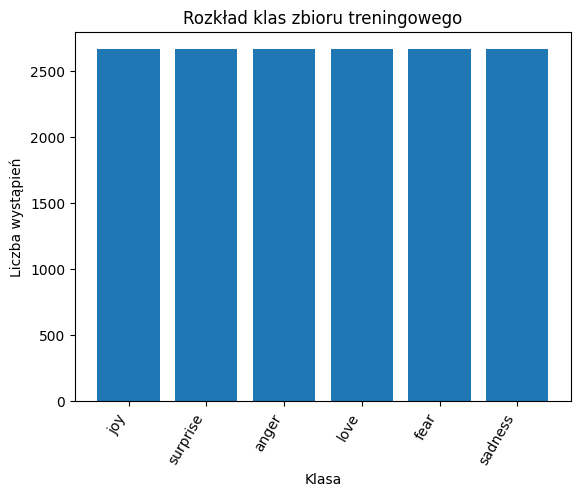

anger       333
surprise    333
love        333
sadness     333
joy         334
fear        334
dtype: int64


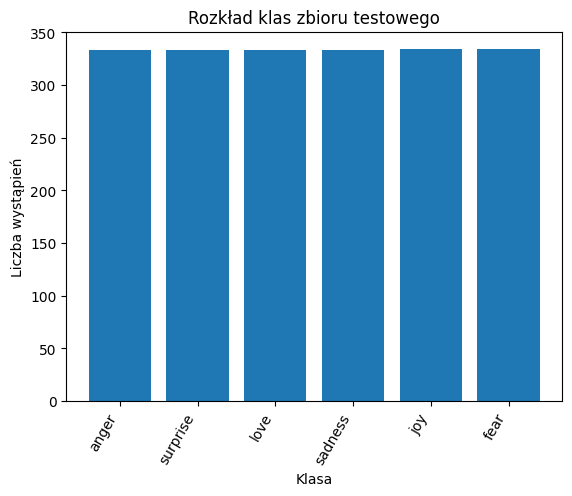

fear        333
joy         333
sadness     333
love        333
anger       334
surprise    334
dtype: int64


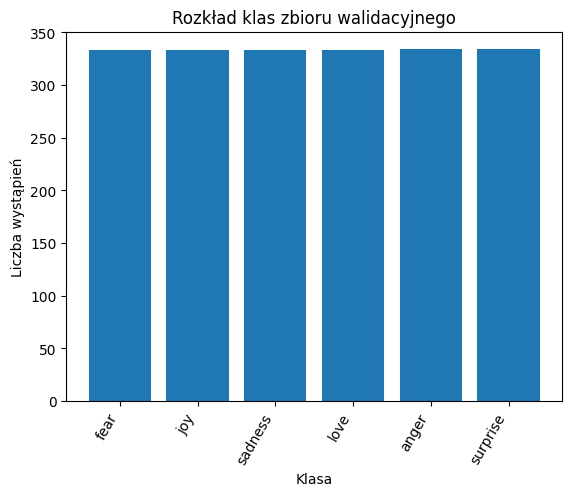

In [12]:
plot_histogram(train, "Rozkład klas zbioru treningowego")
plot_histogram(test, "Rozkład klas zbioru testowego")
plot_histogram(val, "Rozkład klas zbioru walidacyjnego")

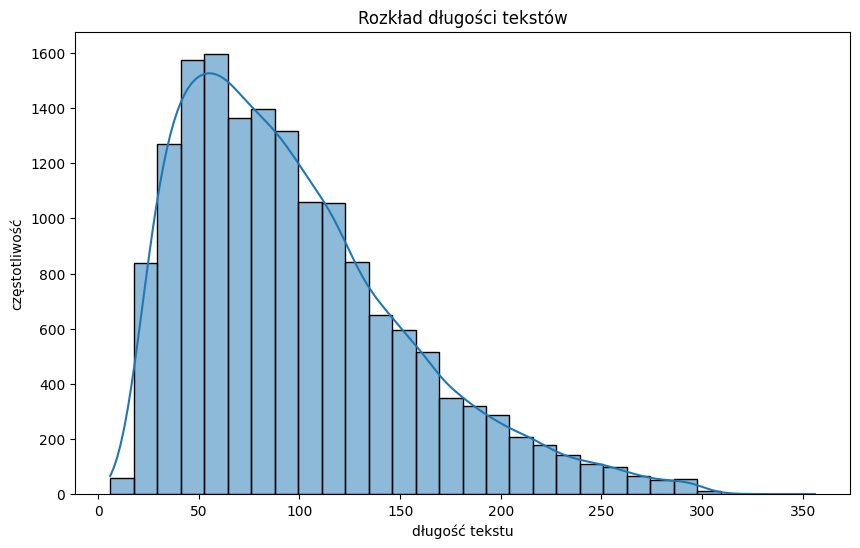

In [13]:
train["text_length"] = train["text"].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train["text_length"], bins=30, kde=True)
plt.title("Rozkład długości tekstów")
plt.xlabel("długość tekstu")
plt.ylabel("częstotliwość")
plt.show()

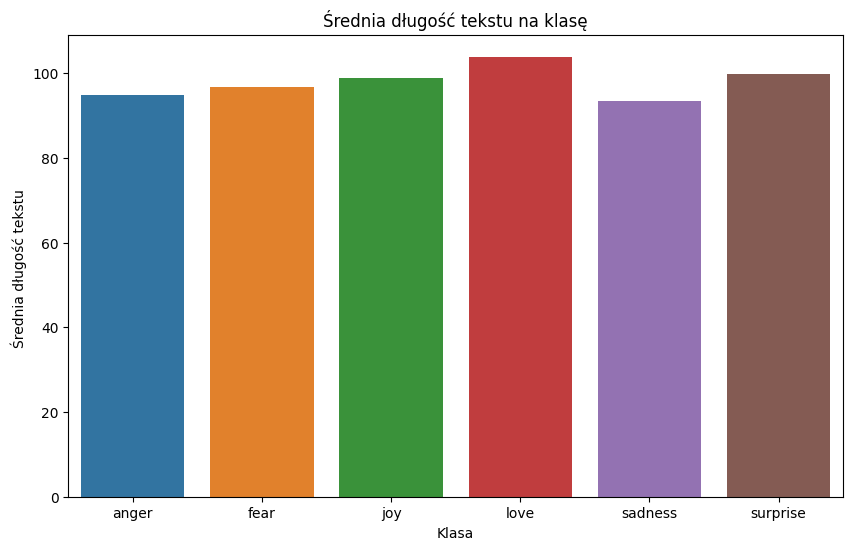

In [19]:
avg_text_length_per_label = (
    train.groupby("label")["text"].apply(

        lambda x: x.str.len().mean()).reset_index()
)
avg_text_length_per_label.columns = ["label", "avg_text_length"]

plt.figure(figsize=(10, 6))
sns.barplot(x="label", y="avg_text_length", data=avg_text_length_per_label)
plt.title("Średnia długość tekstu na klasę")
plt.xlabel("Klasa")
plt.ylabel("Średnia długość tekstu ")
plt.show()

In [15]:
sample_texts = train.sample(5)
for index, row in sample_texts.iterrows():
    print(f"Label: {row['label']}\nText: {row['text']}\n{'=' * 50}")

Label: anger
Text: i feel myself becoming more stressed up and appearing stern again
Label: fear
Text: i feel a lot less restless knowing ill be able to star some assembling soon
Label: love
Text: i was feeling quite hot towards the end of the meal because we were sitting in an enclosed area with weak air conditioning and subjected to the heat from all the stoves around us
Label: love
Text: ive been feeling tender lately about my writing
Label: love
Text: i have not wandered from the way and feel more devoted than ever to the cause of working out the message and example of jesus in my own life


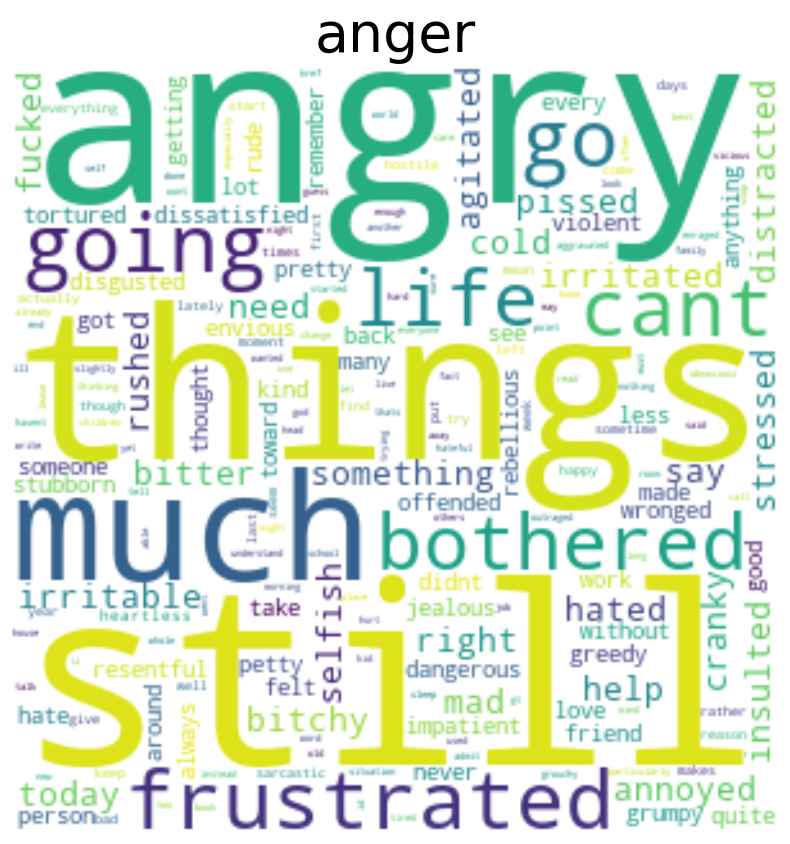

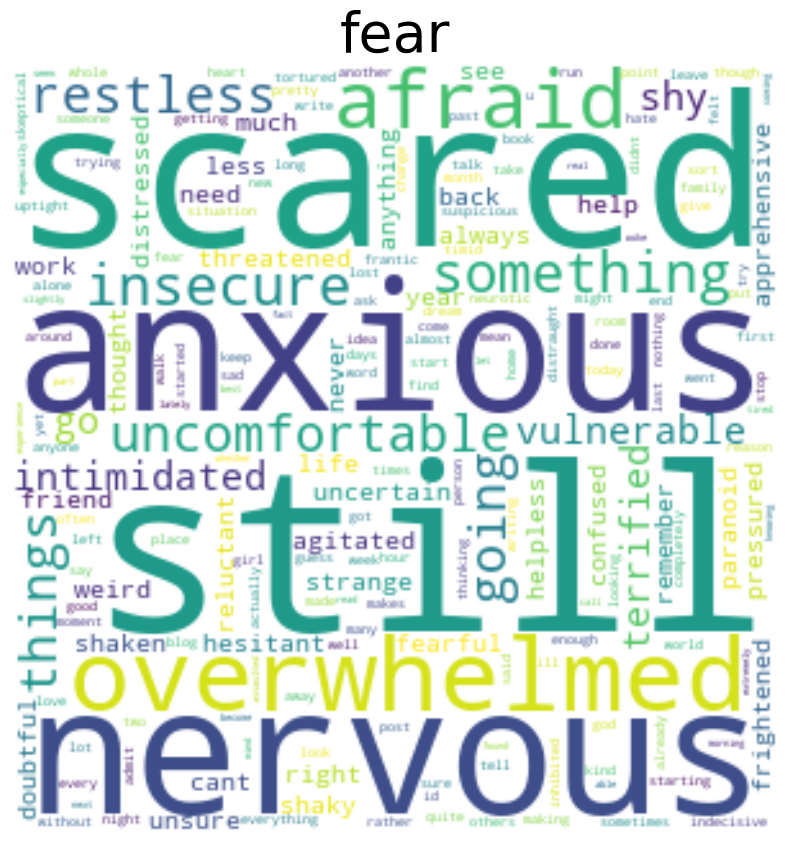

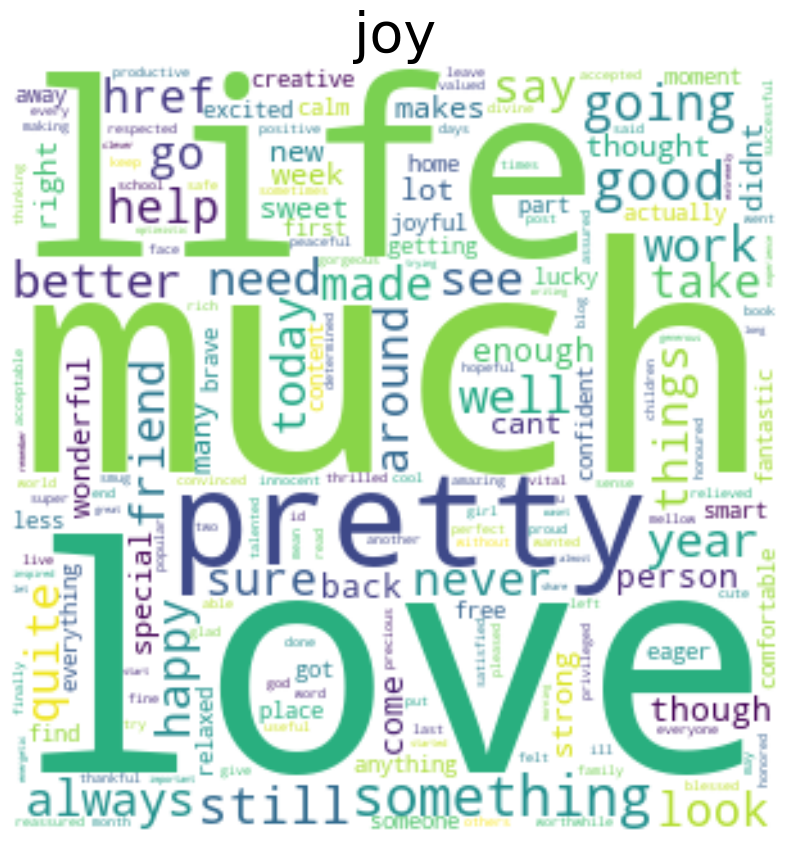

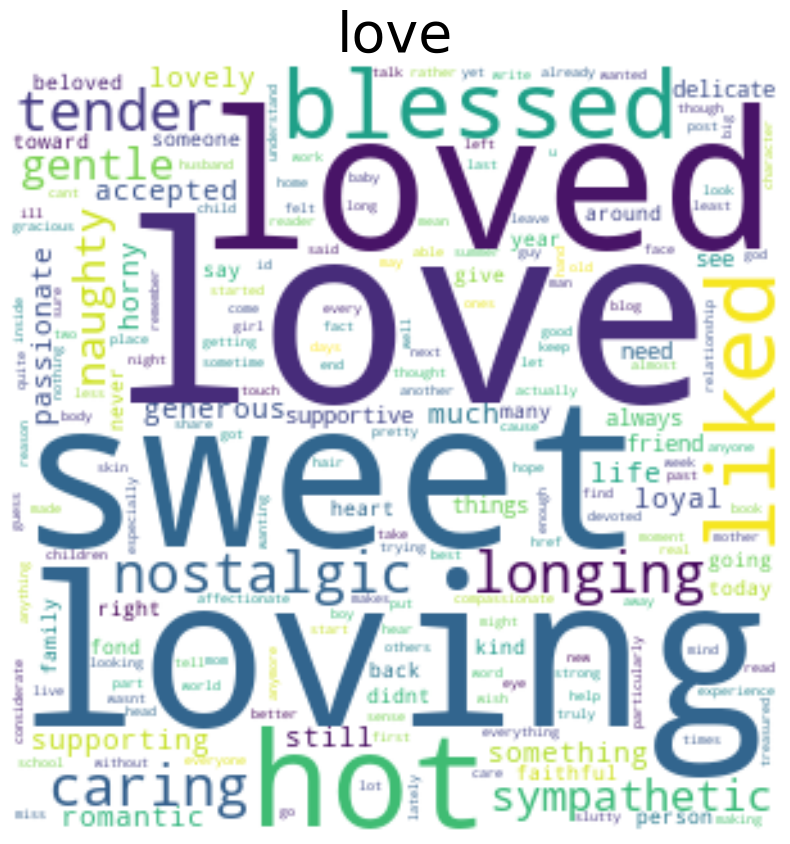

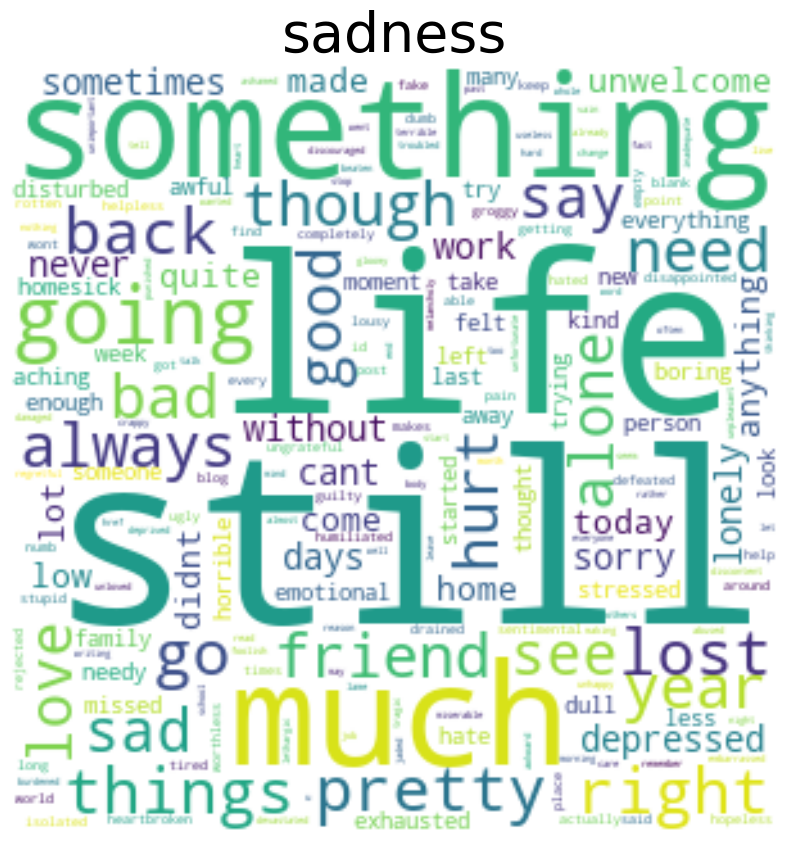

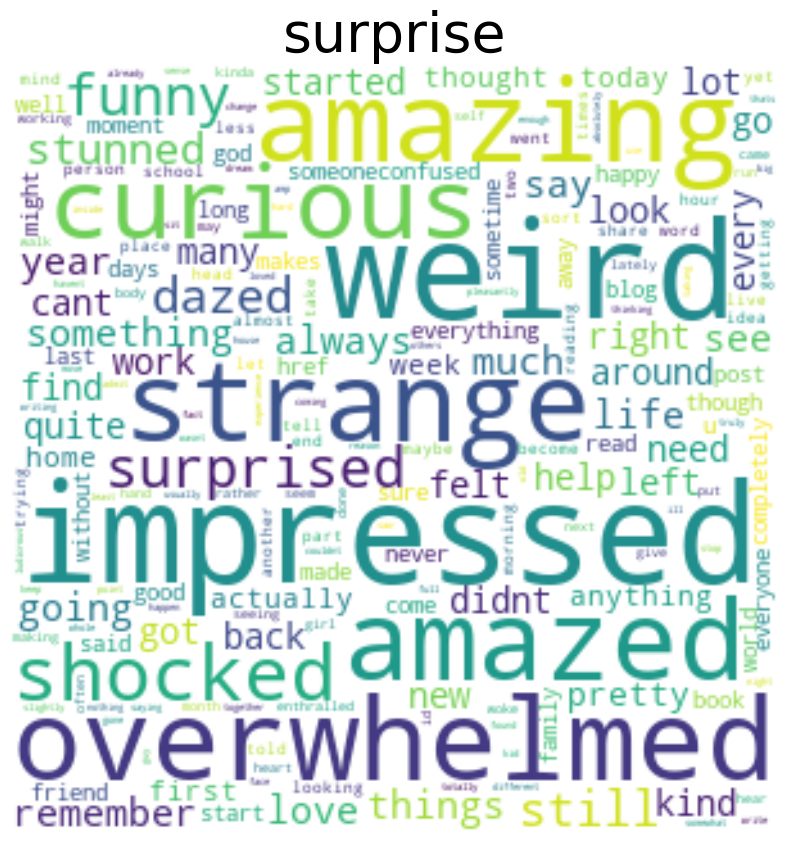

In [16]:
text_by_label = (
    train.groupby("label")["text"].apply(lambda x: " ".join(x)).reset_index()
)

# Create WordCloud for each label
for index, row in text_by_label.iterrows():
    remove_words = [
        "feeling",
        "feel",
        "im",
        "know",
        "really",
        "little",
        "time",
        "people",
        "thing",
        "ive",
        "want",
        "make",
        "think",
        "day",
        "one",
        "dont",
        "bit",
        "way",
        "even",
    ]
    label = row["label"]
    text = row["text"].replace("feeling", "").replace("feel", "")
    text = [
        word
        for word in text.split()
        if word.lower() not in sw_nltk and word.lower() not in remove_words
    ]
    text = " ".join(text)
    wordcloud = WordCloud(
        collocations=False, width=300, height=300, background_color="white"
    ).generate(text)

    # Plot the WordCloud
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"{label}", fontsize=40)
    plt.axis("off")
    plt.show()

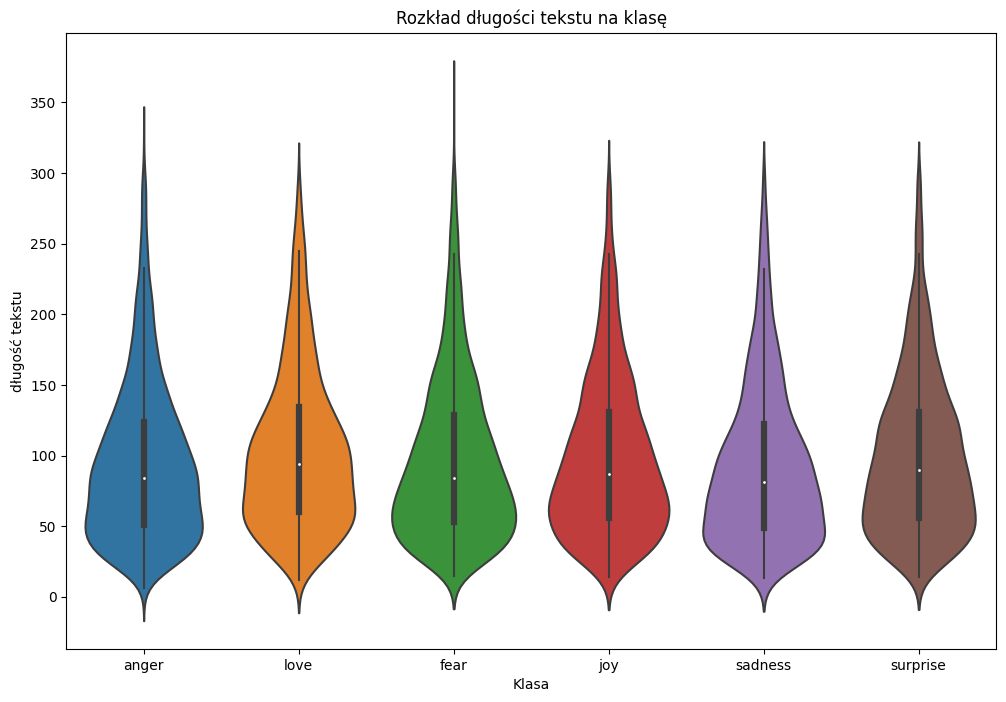

In [17]:
plt.figure(figsize=(12, 8))
sns.violinplot(x="label", y="text_length", data=train)
plt.title("Rozkład długości tekstu na klasę")
plt.xlabel("Klasa")
plt.ylabel("długość tekstu")
plt.show()

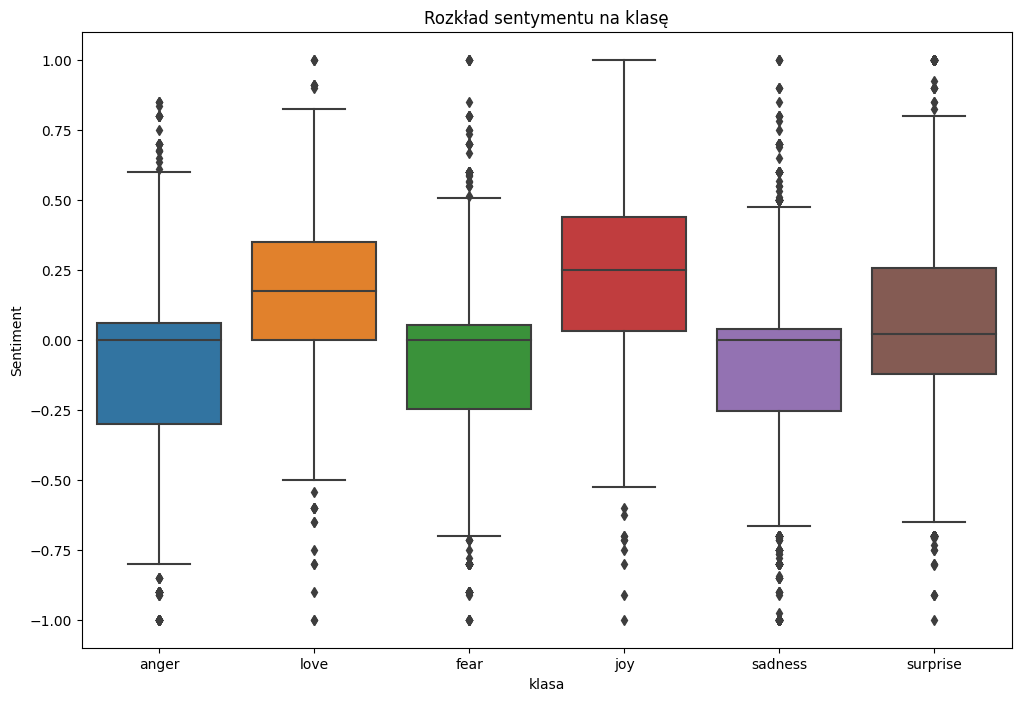

In [18]:
from textblob import TextBlob


def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity


# Apply sentiment analysis to the 'text' column
train["sentiment"] = train["text"].apply(get_sentiment)

# Visualize sentiment distribution per label
plt.figure(figsize=(12, 8))
sns.boxplot(x="label", y="sentiment", data=train)
plt.title("Rozkład sentymentu na klasę")
plt.xlabel("klasa")
plt.ylabel("Sentiment")
plt.show()